# Drug recommender system for patients with Lung Cancer indication

In [1]:
from __future__ import division
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from difflib import SequenceMatcher

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
#import decisiontreeclassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
#import logisticregression classifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#for validating your classification model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# feature selection
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Reading the cleaned dataset

In [25]:
df=pd.read_csv('fda_lungcancer.csv')
df.head()

,drugname,age,gndr_cod,wt,reporter_country,de,lt,ho,ds,ca,ri,ot,pt
0,bibw 2992,79.67,0.0,61.0,country not specified,0,0,1,0,0,0,0,abdominal pain
1,bibw 2992,79.67,0.0,61.0,country not specified,0,0,1,0,0,0,0,blood creatinine increased
2,bibw 2992,79.67,0.0,61.0,country not specified,0,0,1,0,0,0,0,diarrhoea
3,bibw 2992,79.67,0.0,61.0,country not specified,0,0,1,0,0,0,0,pleural effusion
4,bibw 2992,79.67,0.0,61.0,country not specified,0,0,1,0,0,0,0,weight decreased


In [22]:
len(df)

8319

## Data Preprocessing

In [26]:
dummy_col = pd.get_dummies(df[['gndr_cod','drugname']])
df=df.drop(['drugname','gndr_cod','reporter_country','pt'] , axis=1)
df = pd.concat([df, dummy_col], axis=1)
df.head()

,age,wt,de,lt,ho,ds,ca,ri,ot,gndr_cod,...,drugname_vitamin b12 /00056201/,drugname_vorinostat,drugname_vp-16,drugname_xalkori,drugname_xeloda,drugname_xgeva,drugname_yervoy,drugname_zileuton,drugname_zometa,drugname_zykadia
0,79.67,61.0,0,0,1,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,79.67,61.0,0,0,1,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,79.67,61.0,0,0,1,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,79.67,61.0,0,0,1,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,79.67,61.0,0,0,1,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.corr()['de'].sort_values()

ho                                              -0.298437
drugname_xalkori                                -0.046749
ds                                              -0.036395
drugname_zykadia                                -0.035763
drugname_cisplatin                              -0.035216
drugname_bevacizumab                            -0.032160
drugname_tarceva                                -0.027771
pt_atrial fibrillation                          -0.027459
drugname_etoposide                              -0.027273
pt_pyrexia                                      -0.026830
drugname_erlotinib (tablet)                     -0.026810
drugname_dabrafenib                             -0.026373
drugname_gilotrif                               -0.025073
drugname_crizotinib                             -0.023929
pt_infection                                    -0.023580
pt_hypocalcaemia                                -0.023580
drugname_bibw 2992                              -0.023444
pt_oesophagiti

Text(0.5,1,'Selecting k with the Elbow Method')

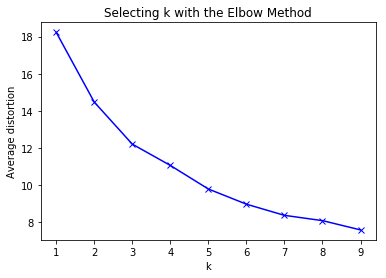

In [6]:
# Clustering to see pattaerns of drugs, age, wt, reactions, ... wihtout outcomes
X=df[['age','wt','gndr_cod']]
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
K = range(1, 10) 

meandistortions = []

for k in K: 
    kmeans = KMeans(n_clusters=k) 
    kmeans.fit(X) 
    meandistortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]) 

plt.plot(K, meandistortions, 'bx-') 
plt.xlabel('k') 
plt.ylabel('Average distortion') 
plt.title('Selecting k with the Elbow Method') 

In [7]:
from sklearn.cluster import KMeans
k_means = KMeans(init='k-means++', n_clusters=5, random_state=0)
k_means.fit(X)
df_cl = pd.DataFrame(k_means.labels_, columns = ['cluster'])
df2 = df.join(df_cl)
df2.head()

,age,wt,de,lt,ho,ds,ca,ri,ot,gndr_cod,...,drugname_zoledronic acid,drugname_zoledronic acid (manufacturer unknown),"drugname_zoledronsyre, actavis",drugname_zoloft,drugname_zolpidem,drugname_zometa,drugname_zometa (zoledronate) solution for injection,drugname_zometa acid,drugname_zophren,cluster
0,74.0,44.0,0,0,0,0,0,0,1,0.0,...,0,0,0,0,0,1,0,0,0,3
1,74.0,44.0,0,0,0,0,0,0,1,0.0,...,0,0,0,0,0,1,0,0,0,3
2,74.0,44.0,0,0,0,0,0,0,1,0.0,...,0,0,0,0,0,1,0,0,0,3
3,74.0,44.0,0,0,0,0,0,0,1,0.0,...,0,0,0,0,0,1,0,0,0,3
4,74.0,44.0,0,0,0,0,0,0,1,0.0,...,0,0,0,0,0,1,0,0,0,3


In [8]:
df2['cluster'].value_counts()

0    7649
3    6636
1    5569
2    4727
4    1188
Name: cluster, dtype: int64

In [24]:
df2.corr()['de'].sort_values()

ho                                    -0.131645
drugname_tamoxifen citrate            -0.049988
drugname_tamoxifen                    -0.048661
ds                                    -0.048325
drugname_lapatinib                    -0.040179
drugname_femara                       -0.035361
drugname_faslodex                     -0.034233
ot                                    -0.030189
drugname_amisfostine                  -0.028821
drugname_pertuzumab                   -0.028581
gndr_cod                              -0.027245
drugname_theratope                    -0.026810
drugname_ibrance                      -0.026320
drugname_docetaxel.                   -0.026058
wt                                    -0.024738
drugname_trastuzumab                  -0.023977
drugname_carboplatin.                 -0.022784
drugname_letrozole                    -0.022000
drugname_cyclophosphamide.            -0.021422
drugname_megace                       -0.021324
drugname_perjeta                      -0

In [9]:
df2[df2['cluster']==0].corr()['de'].sort_values(ascending=False).head(10)

de                               1.000000
drugname_zometa                  0.246045
age                              0.144433
drugname_aredia                  0.109159
drugname_aromasin                0.096235
drugname_arimidex                0.087387
drugname_vinflunine              0.075473
drugname_cgs 20267 t30748+tab    0.071994
drugname_capecitabine            0.070327
drugname_taxol                   0.069502
Name: de, dtype: float64

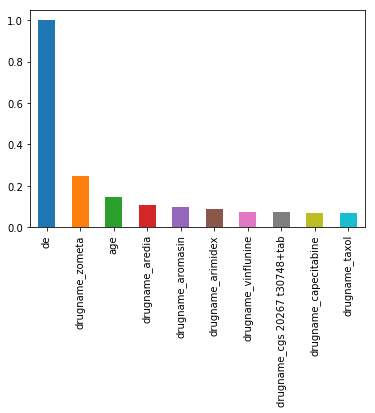

In [10]:
df2[df2['cluster']==0].corr()['de'].sort_values(ascending=False).head(10).plot.bar()

In [11]:
df2[df2['cluster']==1].corr()['de'].sort_values(ascending=False)

de                                                                                1.000000
drugname_nolvadex                                                                 0.281181
drugname_navelbine                                                                0.247651
drugname_aromasine                                                                0.188432
drugname_cyclophosphamide                                                         0.177136
drugname_chlorambucil                                                             0.136747
drugname_paclitaxel sandoz                                                        0.136747
drugname_ixempra kit                                                              0.101537
drugname_cyclophosphamid                                                          0.100949
drugname_vinorelbine                                                              0.098716
drugname_ultravist                                                                0.082409

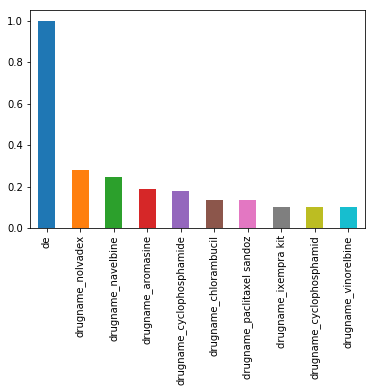

In [12]:
df2[df2['cluster']==1].corr()['de'].sort_values(ascending=False).head(10).plot.bar()

In [13]:
df2[df2['cluster']==2].corr()['de'].sort_values(ascending=False)

de                                                                         1.000000
drugname_farmorubicin                                                      0.137635
drugname_abraxane (paclitaxel)                                             0.134320
drugname_hysron                                                            0.126557
drugname_cgs 20267 t30748+tab                                              0.117818
drugname_xeloda                                                            0.113170
drugname_furtulon                                                          0.093041
drugname_erlotinib hydrochloride                                           0.089499
drugname_mitoxantrone hydrochloride                                        0.077501
drugname_morphine sulfate                                                  0.077501
drugname_topotecan                                                         0.073877
drugname_cgs 20267 t30748+                                                 0

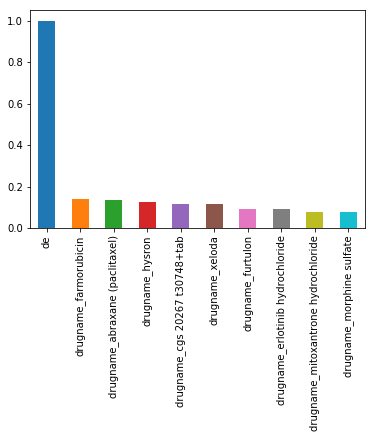

In [17]:
df2[df2['cluster']==2].corr()['de'].sort_values(ascending=False).head(10).plot.bar()

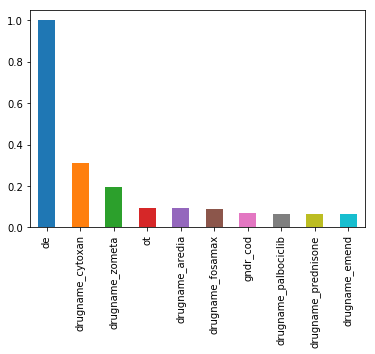

In [18]:
df2[df2['cluster']==3].corr()['de'].sort_values(ascending=False).head(10).plot.bar()

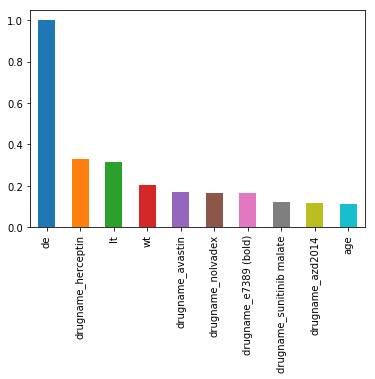

In [19]:
df2[df2['cluster']==4].corr()['de'].sort_values(ascending=False).head(10).plot.bar()

In [22]:
y=df2['de']
X=df2.drop(['wt','gndr_cod','age','de','lt','ho','ds','ca','ri','ot'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
clf1 = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)    #building 100 decision trees
clf1.fit(X_train, y_train)
print "Death model"
print metrics.accuracy_score(y_test, clf1.predict(X_test))

print metrics.confusion_matrix(y_test, clf1.predict(X_test))

Death model
0.7256499805975941
[[1666  660]
 [  47  204]]


## Model Building

In [27]:
y=df['de']
X=df.drop(['de','lt','ho','ds','ca','ri','ot'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
clf1 = RandomForestClassifier(n_estimators=1000, class_weight='balanced', n_jobs=-1, oob_score=True, random_state=0)    #building 100 decision trees
clf1.fit(X_train, y_train)
print "Death model"
print "oob score:", clf1.oob_score_
print metrics.accuracy_score(y_test, clf1.predict(X_test))

print metrics.confusion_matrix(y_test, clf1.predict(X_test))
print "======================================================="
y=df['lt']
X=df.drop(['de','lt','ho','ds','ca','ri','ot'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
clf2 = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, oob_score=True, random_state=0)    #building 100 decision trees
clf2.fit(X_train, y_train)
print "Life threating model"
print "oob score:", clf2.oob_score_
print metrics.accuracy_score(y_test, clf2.predict(X_test))

print metrics.confusion_matrix(y_test, clf2.predict(X_test))
print "======================================================="

y=df['ho']
X=df.drop(['de','lt','ho','ds','ca','ri','ot'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
clf3 = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, oob_score=True, random_state=0)    #building 100 decision trees
clf3.fit(X_train, y_train)
print "Hospitalization model"
print "oob score:", clf3.oob_score_
print metrics.accuracy_score(y_test, clf3.predict(X_test))

print metrics.confusion_matrix(y_test, clf3.predict(X_test))
print "======================================================="

y=df['ds']
X=df.drop(['de','lt','ho','ds','ca','ri','ot'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
clf4 = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, oob_score=True, random_state=0)    #building 100 decision trees
clf4.fit(X_train, y_train)
print "Disability model"
print "oob score:", clf4.oob_score_
print metrics.accuracy_score(y_test, clf4.predict(X_test))

print metrics.confusion_matrix(y_test, clf4.predict(X_test))
print "======================================================="

y=df['ot']
X=df.drop(['de','lt','ho','ds','ca','ri','ot'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
clf5 = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, oob_score=True, random_state=0)    #building 100 decision trees
clf5.fit(X_train, y_train)
print "Other Serious issues model"
print "oob score:", clf5.oob_score_
print metrics.accuracy_score(y_test, clf5.predict(X_test))

print metrics.confusion_matrix(y_test, clf5.predict(X_test))
print "======================================================="

X_test=X_test.reset_index(drop=True)

Death model
oob score: 0.9346867904367571
0.9314903846153846
[[674  24]
 [ 33 101]]
Life threating model
oob score: 0.9667423534125819
0.9639423076923077
[[757  15]
 [ 15  45]]
Hospitalization model
oob score: 0.8278349138506745
0.8173076923076923
[[428  69]
 [ 83 252]]
Disability model
oob score: 0.9941231467877655
0.9927884615384616
[[813   2]
 [  4  13]]
Other Serious issues model
oob score: 0.9469747562441565
0.9290865384615384
[[676  26]
 [ 33  97]]


In [26]:
y=df['de']
X=df.drop(['de','lt','ho','ds','ca','ri','ot'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
clf1 = RandomForestClassifier(n_estimators=100, class_weight='balanced')    #building 100 decision trees
clf1.fit(X_train, y_train)
print "Death model"
print metrics.accuracy_score(y_test, clf1.predict(X_test))

print metrics.confusion_matrix(y_test, clf1.predict(X_test))

Death model
0.9635234769111369
[[2258   68]
 [  26  225]]


In [33]:
svc = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=0)
svc.fit(X_resampled, y_resampled)
print metrics.accuracy_score(y_test, svc.predict(X_test))
print metrics.confusion_matrix(y_test, svc.predict(X_test))

0.6426076833527358
[[1465  861]
 [  60  191]]


In [28]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(activation='tanh' ,solver='lbfgs', alpha=1e-5, random_state=1)
clf.fit(X_resampled, y_resampled)
print metrics.accuracy_score(y_test, clf.predict(X_test))

print metrics.confusion_matrix(y_test, clf.predict(X_test))

0.9041521148622429
[[2313   13]
 [ 234   17]]


In [27]:
from imblearn.under_sampling import TomekLinks
X_resampled, y_resampled = TomekLinks(ratio='not minority').fit_sample(X_train, y_train)
#X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=0, stratify=y)
clf1 = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=0, oob_score=True)    #building 50 decision trees
clf1.fit(X_resampled, y_resampled)
print "Death model"
print "oob score:", clf1.oob_score_
print metrics.accuracy_score(y_test, clf1.predict(X_test))

print metrics.confusion_matrix(y_test, clf1.predict(X_test))

Death model
oob score: 0.9677892918825561
0.9631354287931704
[[2256   70]
 [  25  226]]


In [12]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')    #building 20 decision trees
scores = cross_val_score(clf, X, y, scoring='f1', cv=10)
clf.fit(X, y)
print scores
print scores.mean()

[0.16744186 0.05633803 0.0167364  0.29649596 0.25316456 0.26548673
 0.35412475 0.66666667 0.03550296 0.02020202]
0.21321599237463423


In [13]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [14]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [15]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [16]:
grid_search_wrapper()

Best params for precision_score
{'max_features': 10, 'min_samples_split': 5, 'n_estimators': 100, 'max_depth': 25}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      2159         0
pos        87         8


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 10], 'n_estimators': [100, 300], 'max_depth': [3, 5, 15, 25], 'max_features': [3, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit='precision_score',
       return_train_score=True,
       scoring={'recall_score': make_scorer(recall_score), 'accuracy_score': make_scorer(accuracy_score), 'precision_score': make_scorer(precision_score)},
       verbose=0)

## Function creating

In [19]:
def drug_recommender(age,wt,gndr):
    

    x=np.zeros(X_test.loc[0].shape)
    out=pd.DataFrame(columns={'drug','score'})
    min_prob=1.0
    min_prob_i=3
    for i in range(3,365):
        x = np.zeros(x.shape)
        x[0]=age
        x[1]=wt
        x[2]=gndr
        x[i]=1
        pred=10*clf1.predict_proba(x.reshape(1, -1))[0][1]+3*clf2.predict_proba(x.reshape(1, -1))[0][1]+2*clf3.predict_proba(x.reshape(1, -1))[0][1]+1.5*clf4.predict_proba(x.reshape(1, -1))[0][1]+clf5.predict_proba(x.reshape(1, -1))[0][1]
        prob=pred
        if prob <= min_prob:
            min_prob=prob
            min_prob_i=i
        out=out.append(pd.DataFrame({'drug':[X_test.columns[i]],'score':[pred]}))
    out=out.sort_values(['score'])
    print "Recommended Drug:" ,X_test.columns[min_prob_i].replace("drugname_", "")
    print "=============================================="
    return out.head()

## Tesing

In [20]:
drug_recommender(78,58,0)

Recommended Drug: femara


,drug,score
0,drugname_femara,0.138888
0,drugname_afinitor (rad) unknown,0.138888
0,drugname_letrozole.,0.212692
0,drugname_ibrance,0.280000
0,drugname_aromasine,0.287561
